# Initialize functions

In [1]:
import os
import pandas as pd
import torchvision
import torch
from torchvision import transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image



class CustomImageDataset(Dataset):
    def __init__(self, root_dir,csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(
            ['checazzo', 'peace', 'thumbup', 'ok', 'flat', 'nohandgesture'])}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert("L")


        label = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label]  # Convert string label to integer

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [2]:
seed = 42
generator = torch.Generator().manual_seed(seed)

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


classes = ('checazzo', 'peace', 'thumbup', 'ok', 'flat', 'nohandgesture')

# Set up transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor of shape [1, H, W]
    transforms.Resize((32, 32)), # Resize the image to 32x32
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize the pixel values]
    ])

# Create dataset
dataset = CustomImageDataset(csv_file='images.csv', root_dir=os.getcwd(), transform=transform)
print(dataset.__len__())

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size],generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


Current directory: c:\Visual Computing\Project
6


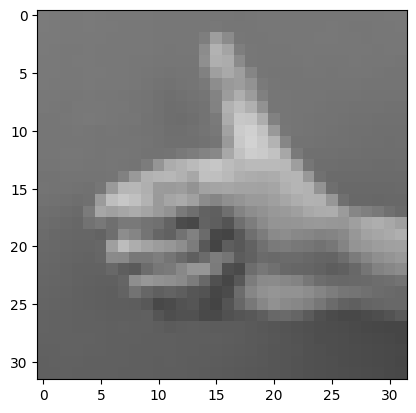

In [3]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Specify gray colormap for grayscale
    plt.show()

# Get some random training images
dataset_iter = iter(train_loader)
images, labels = next(dataset_iter)

# Show images
imshow(make_grid(images))  # Display grid of images

## CNN

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##CNN Architecture

#Generally the CNN output size can be calculated as follows (for an image with same height and width dimensions):
#output_size = (input_size - kernel_size + 2*padding) / stride + 1

#Since we transform each image to grayscale we have 1 input channel.
# Also we use padding, because the most relevant informations lie in the center of the images.csv

#input size of each image: 32x32

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers for regularization
        self.dropout = nn.Dropout(0.5)


        # Fully connected layers
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 6) #6 output classes 5 gestures and 1 for no gesture

    def forward(self, x):
        x = F.relu(self.conv1(x)) # output size = 32x32
        x = self.pool(F.relu(self.conv2(x))) # output size = 16x16

        x = F.relu(self.conv3(x)) #output size = 16x16
        x = self.pool(F.relu(self.conv4(x))) # output size = 8x8

        x = F.relu(self.conv5(x)) #output size = 8x8
        x = self.pool(F.relu(self.conv6(x))) # output size = 4x4

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x) #no activation function because we use CrossEntropyLoss

        return x

In [5]:
#Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 200

# Check if the GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)


model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(model)


cpu
Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=6, bias=True)
)


In [6]:
pip install torchsummary

In [7]:
from torchsummary import summary

summary(model, (1, 32, 32)) # (channels, height, width of input image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
            Conv2d-2           [-1, 16, 32, 32]           1,168
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
            Conv2d-5           [-1, 32, 16, 16]           9,248
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
            Conv2d-8             [-1, 64, 8, 8]          36,928
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 500]         512,500
          Dropout-11                  [-1, 500]               0
           Linear-12                  [-1, 256]         128,256
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [8]:
def train(model, train_loader, optimizer, criterion, n_epochs=None):
    model.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
        #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    return losses


Finished Training


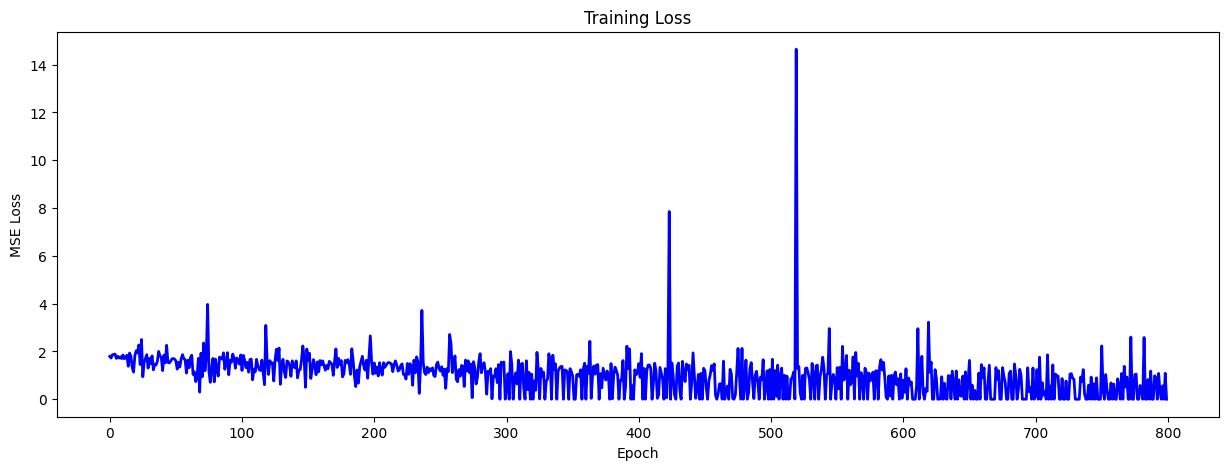

In [9]:
losses = train(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

C:\Users\gabri\AppData\Local\Temp\ipykernel_5660\210957378.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
Clipping input 

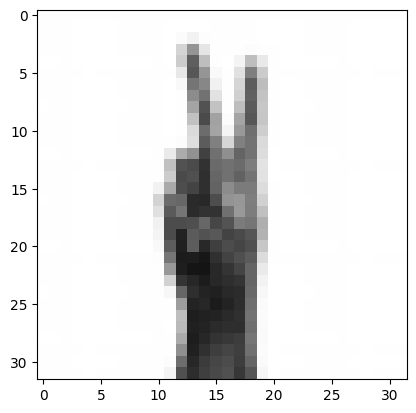

In [10]:
model.load_state_dict(torch.load('model.pth'))

# Check the testset
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))


In [11]:
def test_accuracy(model, test_loader, device='cpu'):
    """
    Calculate and return the accuracy of the model on the test set.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    """
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute overall accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    return accuracy


In [12]:
# Calculate the overall accuracy
overall_accuracy = test_accuracy(model, test_loader, device=device)


Accuracy of the network on the test images: 0.00 %


In [13]:
def accuracy(model, test_loader, classes, device='cpu'):
    """
    Calculate and print the accuracy for each class.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - class_accuracies: A dictionary with class names as keys and accuracy percentages as values
    """
    # Switch the model to evaluation mode
    model.eval()

    # Initialize variables for correct and total counts per class
    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Compute and print accuracy for each class
    class_accuracies = {}
    for i in range(len(classes)):
        if class_total[i] > 0:  # Check to avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]} : {accuracy:.2f} %')
            class_accuracies[classes[i]] = accuracy
        else:
            print(f'Accuracy of {classes[i]} : No samples available')
            class_accuracies[classes[i]] = None

    return class_accuracies


In [14]:
# Call the accuracy function
class_accuracies = accuracy(model, test_loader, classes, device=device)


Accuracy of checazzo : No samples available
Accuracy of peace : 0.00 %
Accuracy of thumbup : No samples available
Accuracy of ok : No samples available
Accuracy of flat : No samples available
Accuracy of nohandgesture : 0.00 %


## Evaluation

In [15]:
from sklearn.metrics import f1_score

def calculate_f1_score(y_true, y_pred, average='weighted'):
    """
    Calculate the F1 score for a classification problem.

    Parameters:
    - y_true: List or array of true class labels
    - y_pred: List or array of predicted class labels
    - average: The averaging method ('micro', 'macro', or 'weighted')

    Returns:
    - f1: F1 score (float)
    """
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"F1 Score ({average}): {f1:.2f}")
    return f1


In [16]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and visualize results
def evaluate_model(model, test_loader, label_map, device='cpu',average='weighted'):
    """
    Evaluate the model on a test set and visualize the results.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - label_map: Dictionary mapping class indices to class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    - conf_matrix: Confusion matrix of the test set predictions
    """
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Compute accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_labels)
    accuracy = 100 * correct / total

    #Compute F1 score
    f1 = calculate_f1_score(all_labels, all_preds, average=average)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print accuracy
    print(f"Accuracy of the network on the test set: {accuracy:.2f}%")

    # Visualize confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", 
                xticklabels=label_map.values(), 
                yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix, f1


F1 Score (weighted): 0.00
Accuracy of the network on the test set: 0.00%


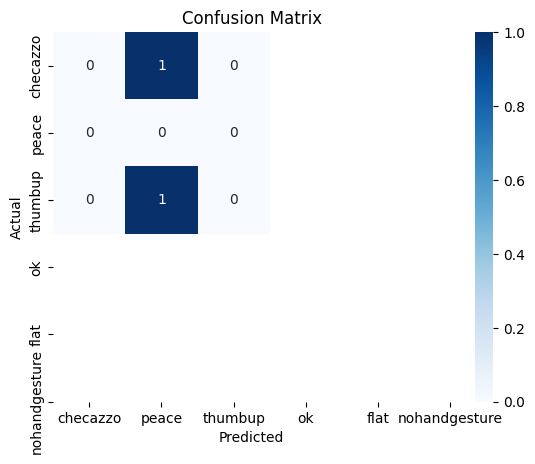

In [17]:
# Define the label map
label_map = {i: class_name for i, class_name in enumerate(classes)}

# Evaluate the model
overall_accuracy, confusion_mat, f1 = evaluate_model(model, test_loader, label_map, device=device,average='weighted')


# Train CNN with augmented data

# Evaluate Model